In [154]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

import math

np.set_printoptions(suppress=True)
%config InlineBackend.figure_format = 'retina'

In [155]:
df = pd.read_csv('rocketfuel_data.csv')

In [156]:
df.head()

,user_id,test,converted,tot_impr,mode_impr_day,mode_impr_hour
0,1069124,1,0,130,1,20
1,1119715,1,0,93,2,22
2,1144181,1,0,21,2,18
3,1435133,1,0,355,2,10
4,1015700,1,0,276,5,14


In [157]:
df.dtypes

user_id           int64
test              int64
converted         int64
tot_impr          int64
mode_impr_day     int64
mode_impr_hour    int64
dtype: object

In [158]:
df.shape

(588101, 6)

In [159]:
pd.concat([df.test.value_counts(), df.test.value_counts(normalize=True)], 
          keys=['count','percentage'],
          axis=1)

,count,percentage
1,564577,0.96
0,23524,0.04


In [160]:
pd.crosstab(df.test, df.converted, normalize=False, margins=True)

converted,0,1,All
test,,,
0,23104,420,23524
1,550154,14423,564577
All,573258,14843,588101


In [161]:
pd.concat([df[df.test==0].converted.value_counts(), df[df.test==0].converted.value_counts(normalize=True)], 
          keys=['count','percentage'],
          axis=1)

,count,percentage
0,23104,0.982146
1,420,0.017854


In [162]:
pd.concat([df[df.test==1].converted.value_counts(), df[df.test==1].converted.value_counts(normalize=True)], 
          keys=['count','percentage'],
          axis=1)

,count,percentage
0,550154,0.974453
1,14423,0.025547


# Part-1: Was the advertising campaign effective?

a. Explain the experimental setup, describe what the control group was exposed to and what
would be some alternatives.

> Treatment group was exposed to the campaign ad, while the control group (4%) was exposed to
a public service announcement (PSA) such as Mothers Against Drunk Driving (MADD), Wilfire Prevention etc. An alternative would have been to not show anything to the control group users.

b. Did additional consumers convert as a result of the ad campaign? Compare the test and
control groups and run a statistical test.

> **Check analysis below**

c. Discuss why the control and test groups were randomized and how you can reassure
Taskabella that randomization was properly done.

> Randomization is done in an experiment to ensure there are no observed/unobserved heterogenity in the two populations. If the treatment user is shown the campaign ad based on whether they are more likely to convert, then the randomization is not done correctly.

d. Was the size of the control group properly chosen, would you recommend a different size for
the next experiment?

> Control group size is small. **Need more research on this**

# One tailed T-Test between treatment and control conversion

**Null Hypothesis: Conversion rate of treatment group is <= Conversion rate of control group**

**Alternative Hypothesis: Conversion rate of treatment group is > Conversion rate of control group**

In [163]:
n = len(df)
n_t = len(df[df['test'] == 1])
n_c = len(df[df['test'] == 0])
print(f"Total users={n}, treatment={n_t}, control={n_c}")

Total users=588101, treatment=564577, control=23524


In [164]:
condition_treatment_converted = (df['test'] == 1) & (df['converted'] == 1)
condition_control_converted = (df['test'] == 0) & (df['converted'] == 1)

In [165]:
p_t = round(len(df[condition_treatment_converted]) / len(df[df['test'] == 1]),4)
p_c = round(len(df[condition_control_converted]) / len(df[df['test'] == 0]), 4)
print(p_t, p_c)

0.0255 0.0179


In [166]:
s_t = round(math.sqrt((p_t*(1 - p_t))/n_t),4)
s_c = round(math.sqrt((p_c*(1 - p_c))/n_c),4)
print(s_t, s_c)

0.0002 0.0009


In [167]:
# SE for T-Test
se = round(math.sqrt( p_t*(1 - p_t)/n_t + p_c*(1 - p_c)/n_c), 4)
se

0.0009

In [168]:
z = (p_t - p_c)/se
z

8.444444444444443

**The critical Z score with an alpha of 0.05 (one tailed) is 1.645. Since 8.44 >> 1.645, we reject the null hypothesis. The campaign, as executed, helped in ad conversion.**

# Part-2: Was the campaign profitable?

a. What is the expected financial impact from the conversions resulting from the ads (excluding
all advertising costs)? In other words, how much more money is TaskaBella making by
running the advertising?

b. How much was the cost of the ad campaign?

c. Calculate the ROI of the campaign. Was the campaign worth it?

d. What was the opportunity cost of including a control group; how much more could have
TaskaBella made with a smaller control group or not having a control group at all?

In [169]:
""" 
Effect of ads = conversion due to ads = 
conversion rate of treatment group * size of treated group - conversion of control group * size of treated group
"""
(p_t * n_t - p_c * n_t) * 40

171631.408

In [170]:
# Cost of ad campaign at CPM of $9 =  (total impressions / 1000) * 9
(sum(df['tot_impr'])/1000) * 9

131374.638

In [171]:
# ROI = Revenue due to campaign - Cost of campaign
roi = (p_t * n_t - p_c * n_t) * 40 - (sum(df['tot_impr'])/1000) * 9
roi

40256.76999999999

# Part-3: How did the number of impressions seen by each user influence the effectiveness of advertising?

a. Plot the percentage of users converting among those in the control group and among those
exposed to the ad as functions of impressions seen (number of impressions on x axis,
percentage of converting users on y axis). Group together numbers of impressions as
necessary to obtain a meaningful plot and pick a reasonable range for the highest number of
impressions displayed.

b. What can you infer from the plot? In what region is advertising most effective?

c. What do the above figures imply for the design of the next campaign assuming that consumer
response would be similar?

In [172]:
df['tot_impr'].describe(percentiles=[r for r in np.arange(0,1,0.05)]+[0.96,0.97,0.98,0.99])

count    588101.000000
mean         24.820876
std          43.715181
min           1.000000
0%            1.000000
5%            1.000000
10%           2.000000
15%           2.000000
20%           3.000000
25%           4.000000
30%           5.000000
35%           7.000000
40%           8.000000
45%          11.000000
50%          13.000000
55%          15.000000
60%          17.000000
65%          20.000000
70%          24.000000
75%          27.000000
80%          33.000000
85%          42.000000
90%          57.000000
95%          88.000000
96%          99.000000
97%         116.000000
98%         143.000000
99%         202.000000
max        2065.000000
Name: tot_impr, dtype: float64

<Axes: xlabel='tot_impr', ylabel='Count'>

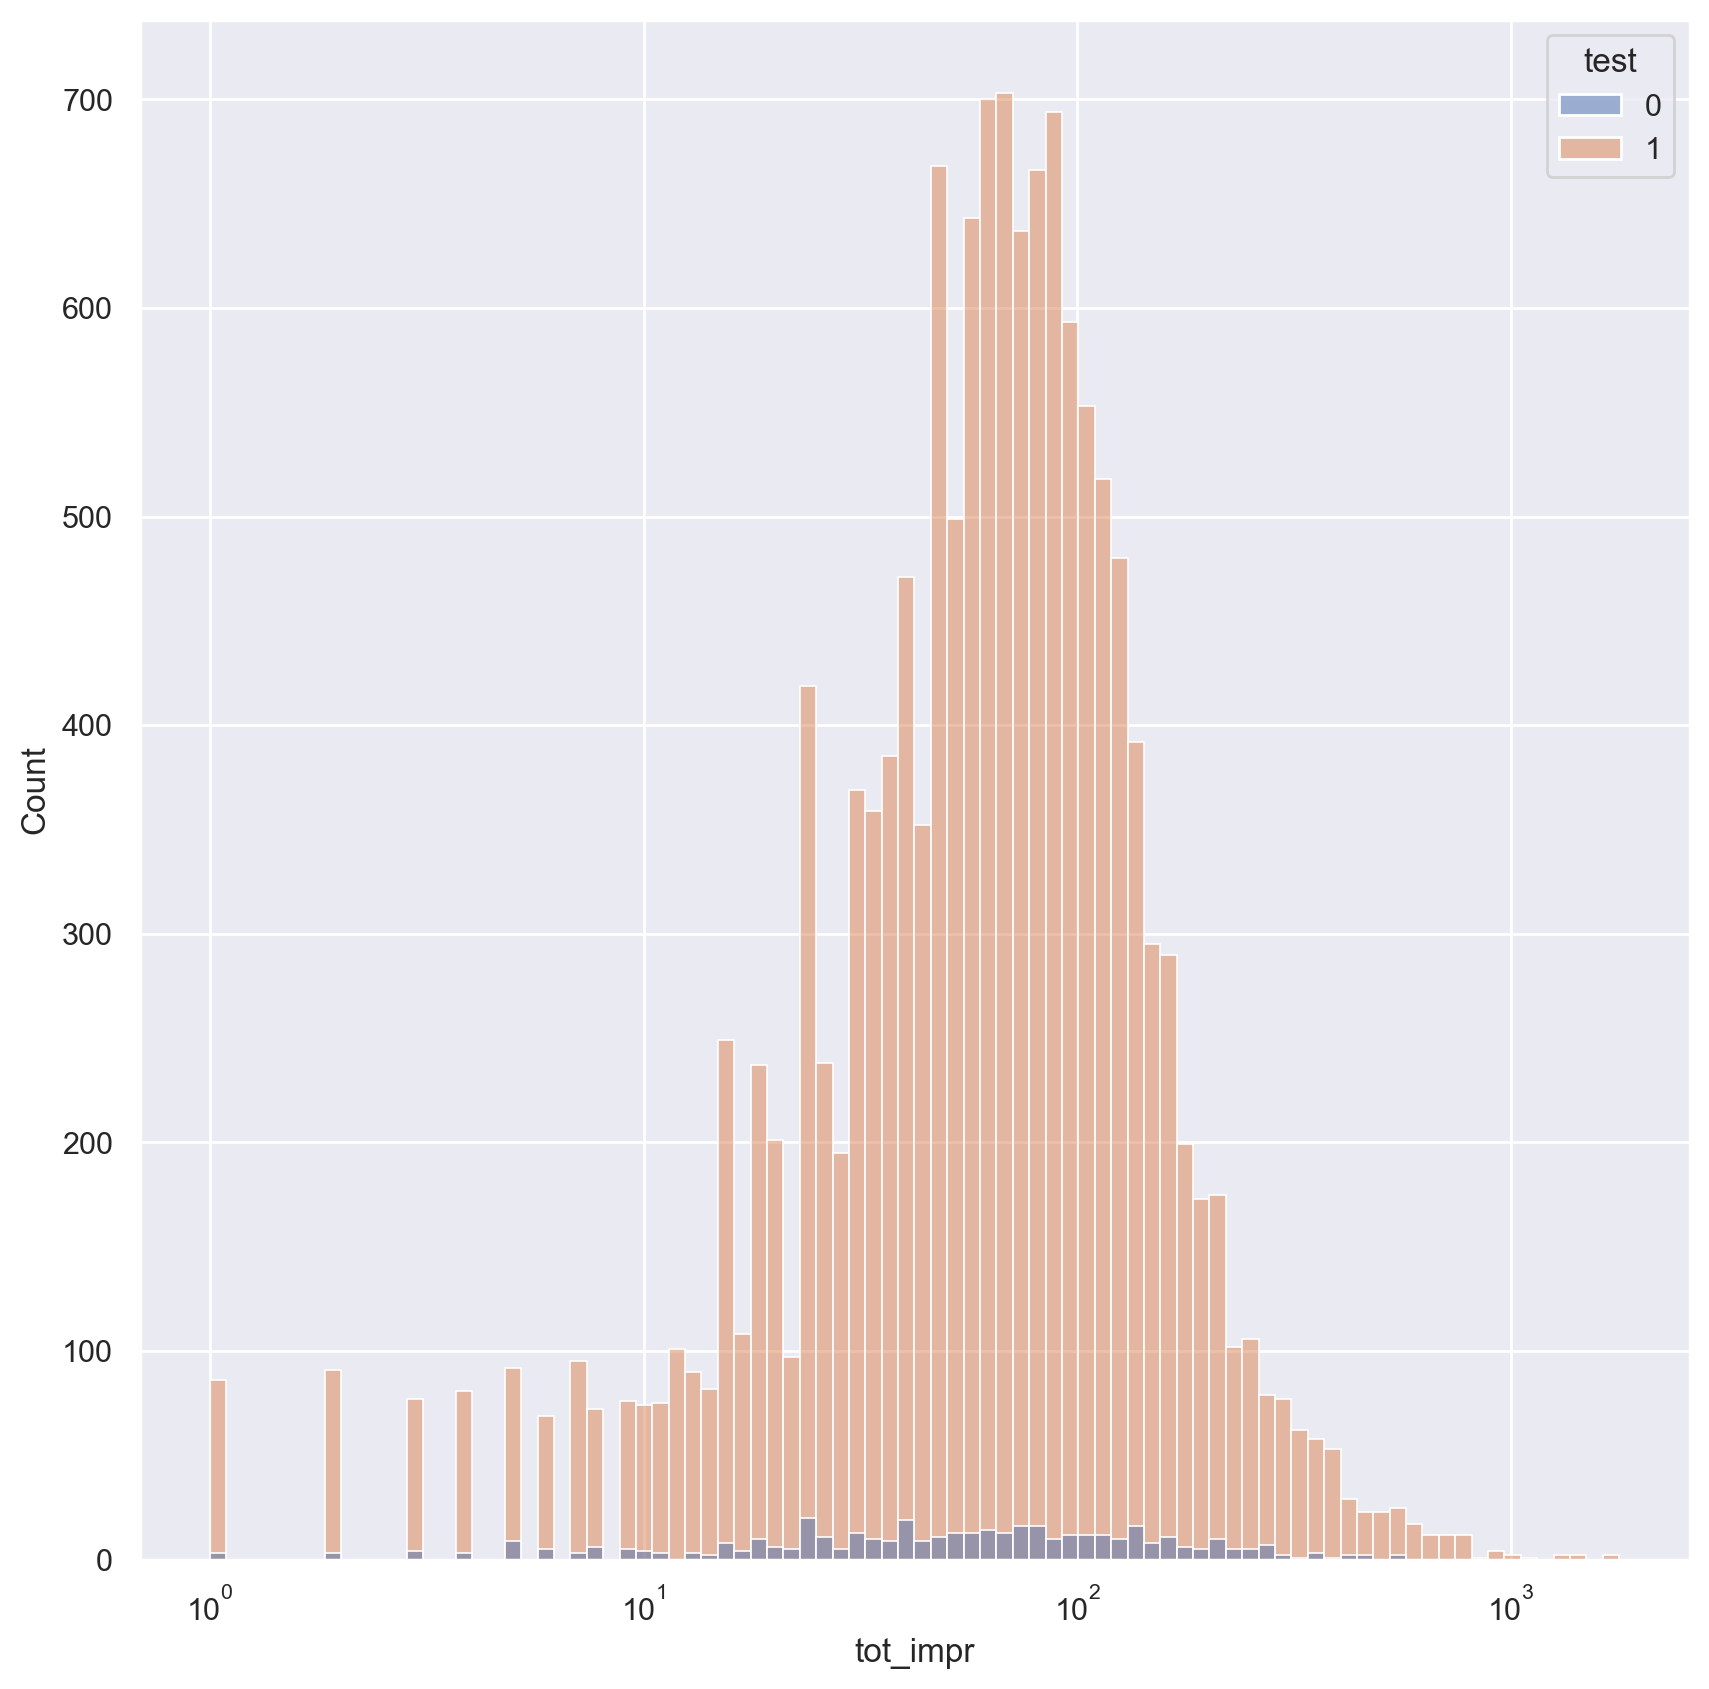

In [173]:
#sns.set(rc={'figure.figsize':(10,10)})
sns.histplot(data=df[df.converted==1], x="tot_impr", hue="test", log_scale=True)

In [174]:
bins = [r for r in range(0,210,10)] + [250,500,1000,2000,2500]  # Adjust the bin edges as needed
bins

[0,
 10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200,
 250,
 500,
 1000,
 2000,
 2500]

In [175]:
df['tot_impr_bins'] = pd.cut(df['tot_impr'], bins=bins)
df.head()

,user_id,test,converted,tot_impr,mode_impr_day,mode_impr_hour,tot_impr_bins
0,1069124,1,0,130,1,20,"(120, 130]"
1,1119715,1,0,93,2,22,"(90, 100]"
2,1144181,1,0,21,2,18,"(20, 30]"
3,1435133,1,0,355,2,10,"(250, 500]"
4,1015700,1,0,276,5,14,"(250, 500]"


In [176]:
df1 = df.groupby(by=['test','tot_impr_bins'])['converted'].sum().reset_index()
df1

,test,tot_impr_bins,converted
0,0,"(0, 10]",45
1,0,"(10, 20]",34
2,0,"(20, 30]",46
3,0,"(30, 40]",40
4,0,"(40, 50]",28
5,0,"(50, 60]",29
6,0,"(60, 70]",24
7,0,"(70, 80]",26
8,0,"(80, 90]",12
9,0,"(90, 100]",16


In [177]:
df1['converted_pct_binned'] = df1.apply(lambda row: row['converted']/n_t if row['test'] == 1 
                                                    else row['converted']/n_c, 
                                        axis=1)
df1

,test,tot_impr_bins,converted,converted_pct_binned
0,0,"(0, 10]",45,0.001913
1,0,"(10, 20]",34,0.001445
2,0,"(20, 30]",46,0.001955
3,0,"(30, 40]",40,0.001700
4,0,"(40, 50]",28,0.001190
5,0,"(50, 60]",29,0.001233
6,0,"(60, 70]",24,0.001020
7,0,"(70, 80]",26,0.001105
8,0,"(80, 90]",12,0.000510
9,0,"(90, 100]",16,0.000680


[Text(0, 0, '(0, 10]'),
 Text(1, 0, '(10, 20]'),
 Text(2, 0, '(20, 30]'),
 Text(3, 0, '(30, 40]'),
 Text(4, 0, '(40, 50]'),
 Text(5, 0, '(50, 60]'),
 Text(6, 0, '(60, 70]'),
 Text(7, 0, '(70, 80]'),
 Text(8, 0, '(80, 90]'),
 Text(9, 0, '(90, 100]'),
 Text(10, 0, '(100, 110]'),
 Text(11, 0, '(110, 120]'),
 Text(12, 0, '(120, 130]'),
 Text(13, 0, '(130, 140]'),
 Text(14, 0, '(140, 150]'),
 Text(15, 0, '(150, 160]'),
 Text(16, 0, '(160, 170]'),
 Text(17, 0, '(170, 180]'),
 Text(18, 0, '(180, 190]'),
 Text(19, 0, '(190, 200]'),
 Text(20, 0, '(200, 250]'),
 Text(21, 0, '(250, 500]'),
 Text(22, 0, '(500, 1000]'),
 Text(23, 0, '(1000, 2000]'),
 Text(24, 0, '(2000, 2500]')]

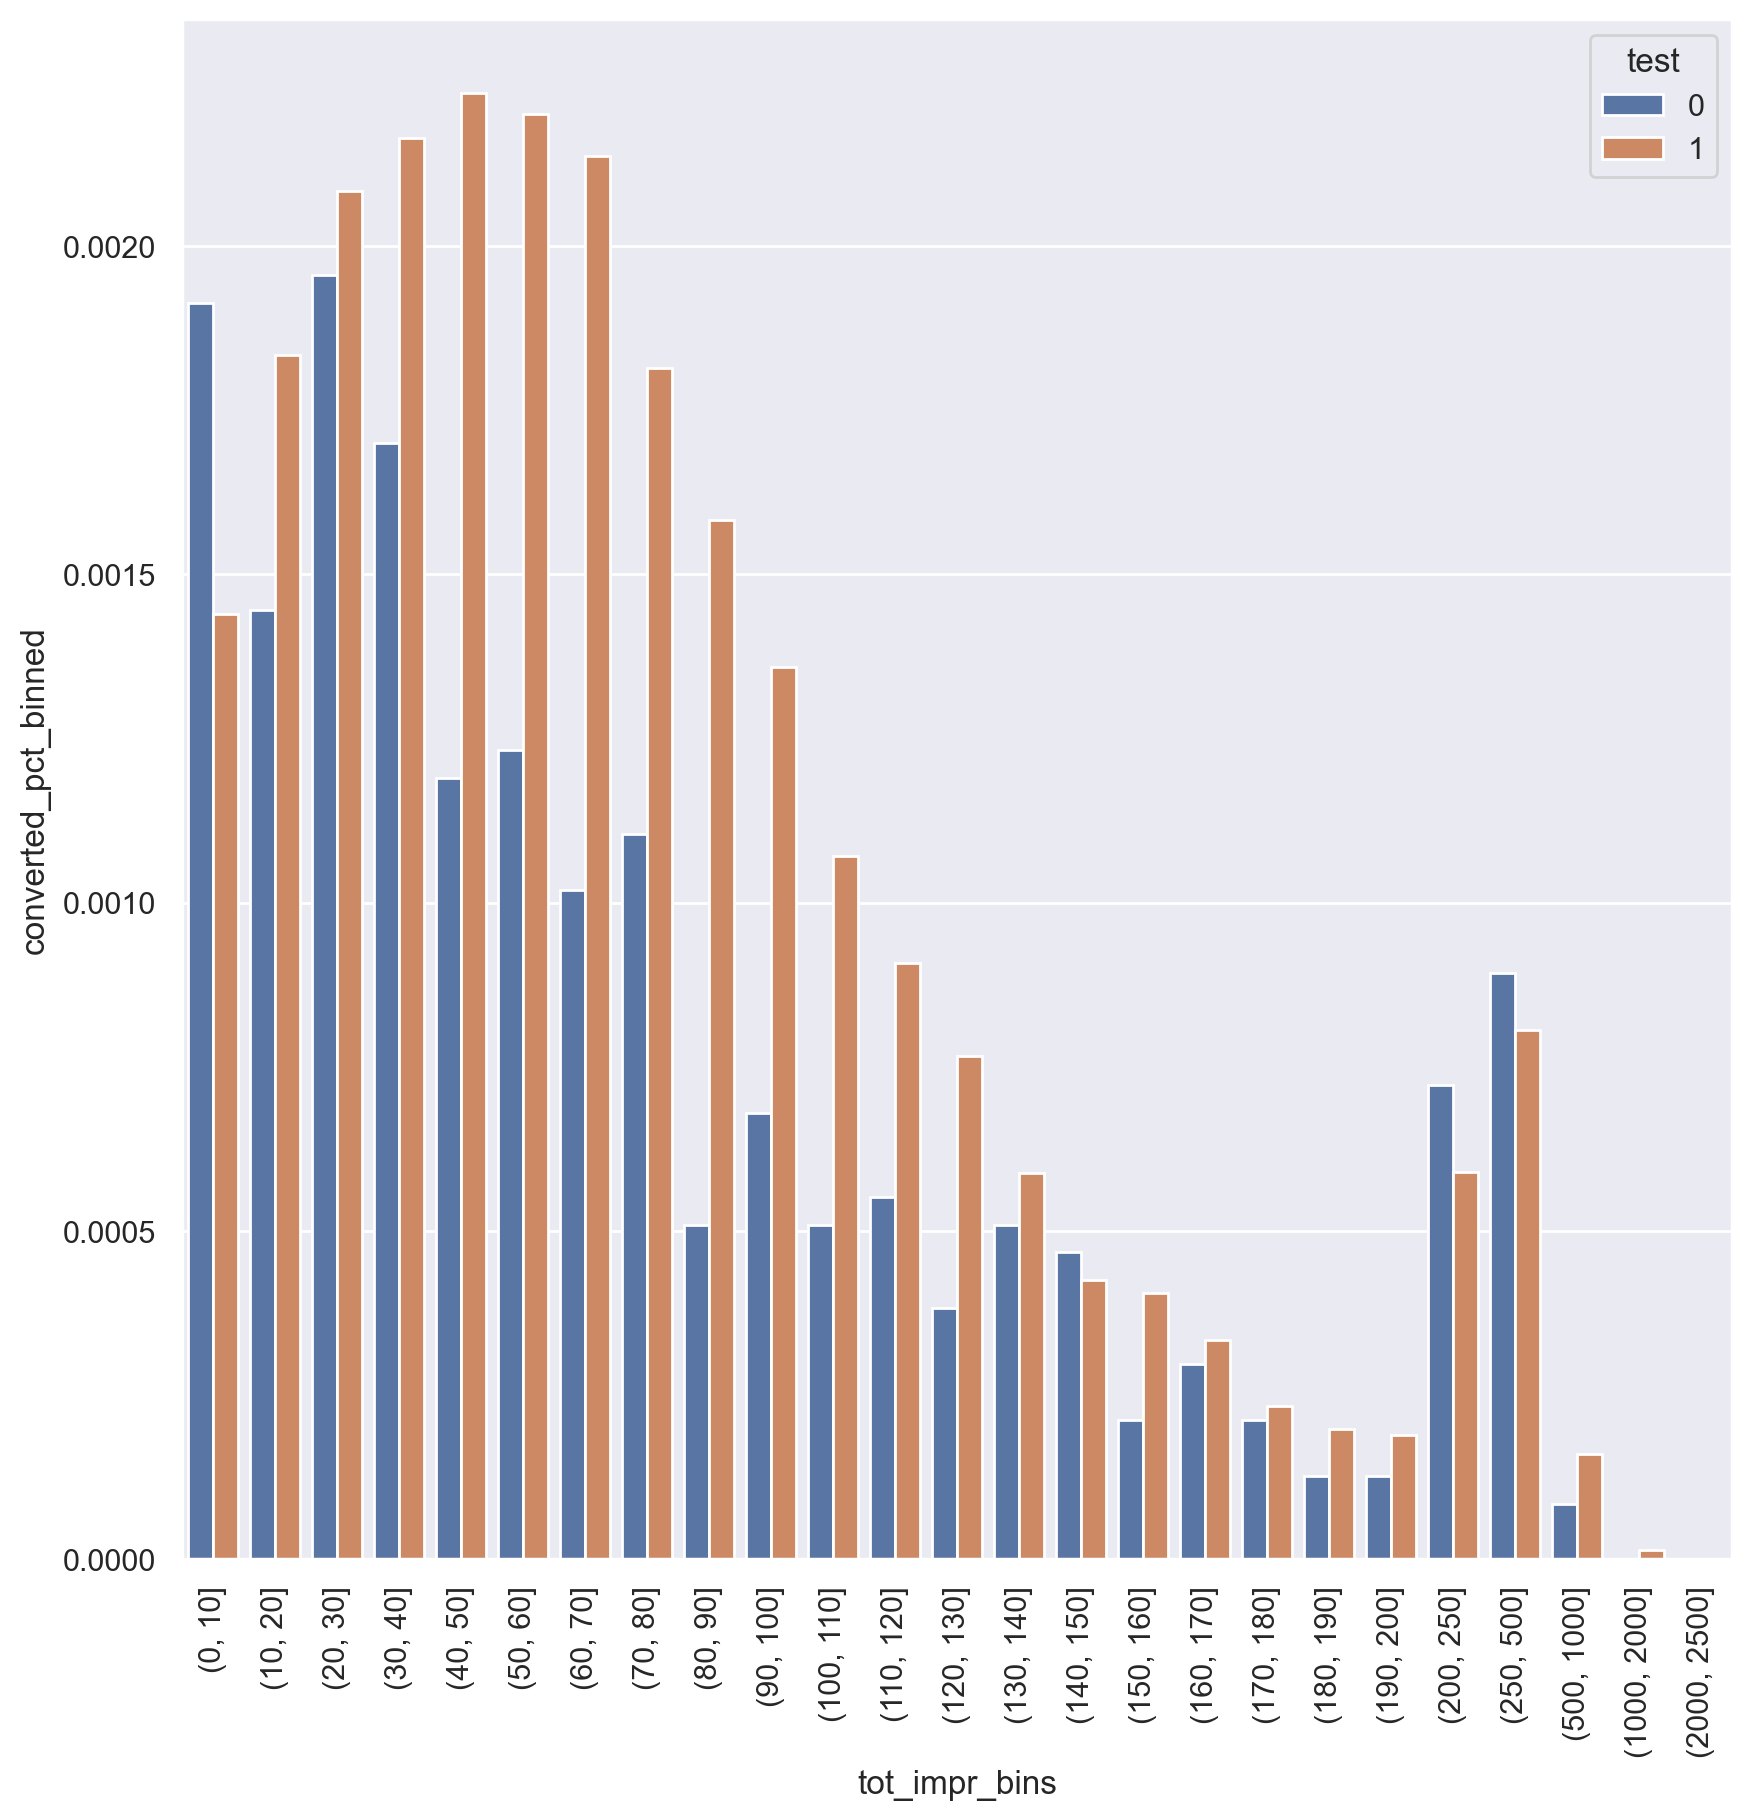

In [178]:
pt = sns.barplot(data=df1, x="tot_impr_bins", y="converted_pct_binned", hue="test")
pt.set_xticklabels(pt.get_xticklabels(), rotation=90)


- Ad campaign is most effective when impressions are between 20 and 140 & most promiment between 30 and 130
- Limit the num of impression to the same user within 130 to save on ad costs / CPM

# Part 4: 

How does consumer response to advertising vary on different days of the week and at different times
of the day?

a. Plot the percentage of users converting among those in the control group and among those
exposed to the ad as a function of the day of the week (mode_impr_day on x axis, percentage
of converting users on y axis )

b. Draw the same plot for hours within a day (mode_impr_hour, excluding the period between
midnight and 8am).

c. What days/hours is advertising the most/least effective?

In [179]:
df2 = df.groupby(by=['test','mode_impr_day'])['converted'].sum().reset_index()
df2

,test,mode_impr_day,converted
0,0,1,79
1,0,2,42
2,0,3,55
3,0,4,79
4,0,5,62
5,0,6,40
6,0,7,63
7,1,1,2778
8,1,2,2270
9,1,3,1963


In [180]:
df2['converted_pct_binned'] = df2.apply(lambda row: row['converted']/n_t if row['test'] == 1 
                                                    else row['converted']/n_c, 
                                        axis=1)
df2

,test,mode_impr_day,converted,converted_pct_binned
0,0,1,79,0.003358
1,0,2,42,0.001785
2,0,3,55,0.002338
3,0,4,79,0.003358
4,0,5,62,0.002636
5,0,6,40,0.001700
6,0,7,63,0.002678
7,1,1,2778,0.004920
8,1,2,2270,0.004021
9,1,3,1963,0.003477


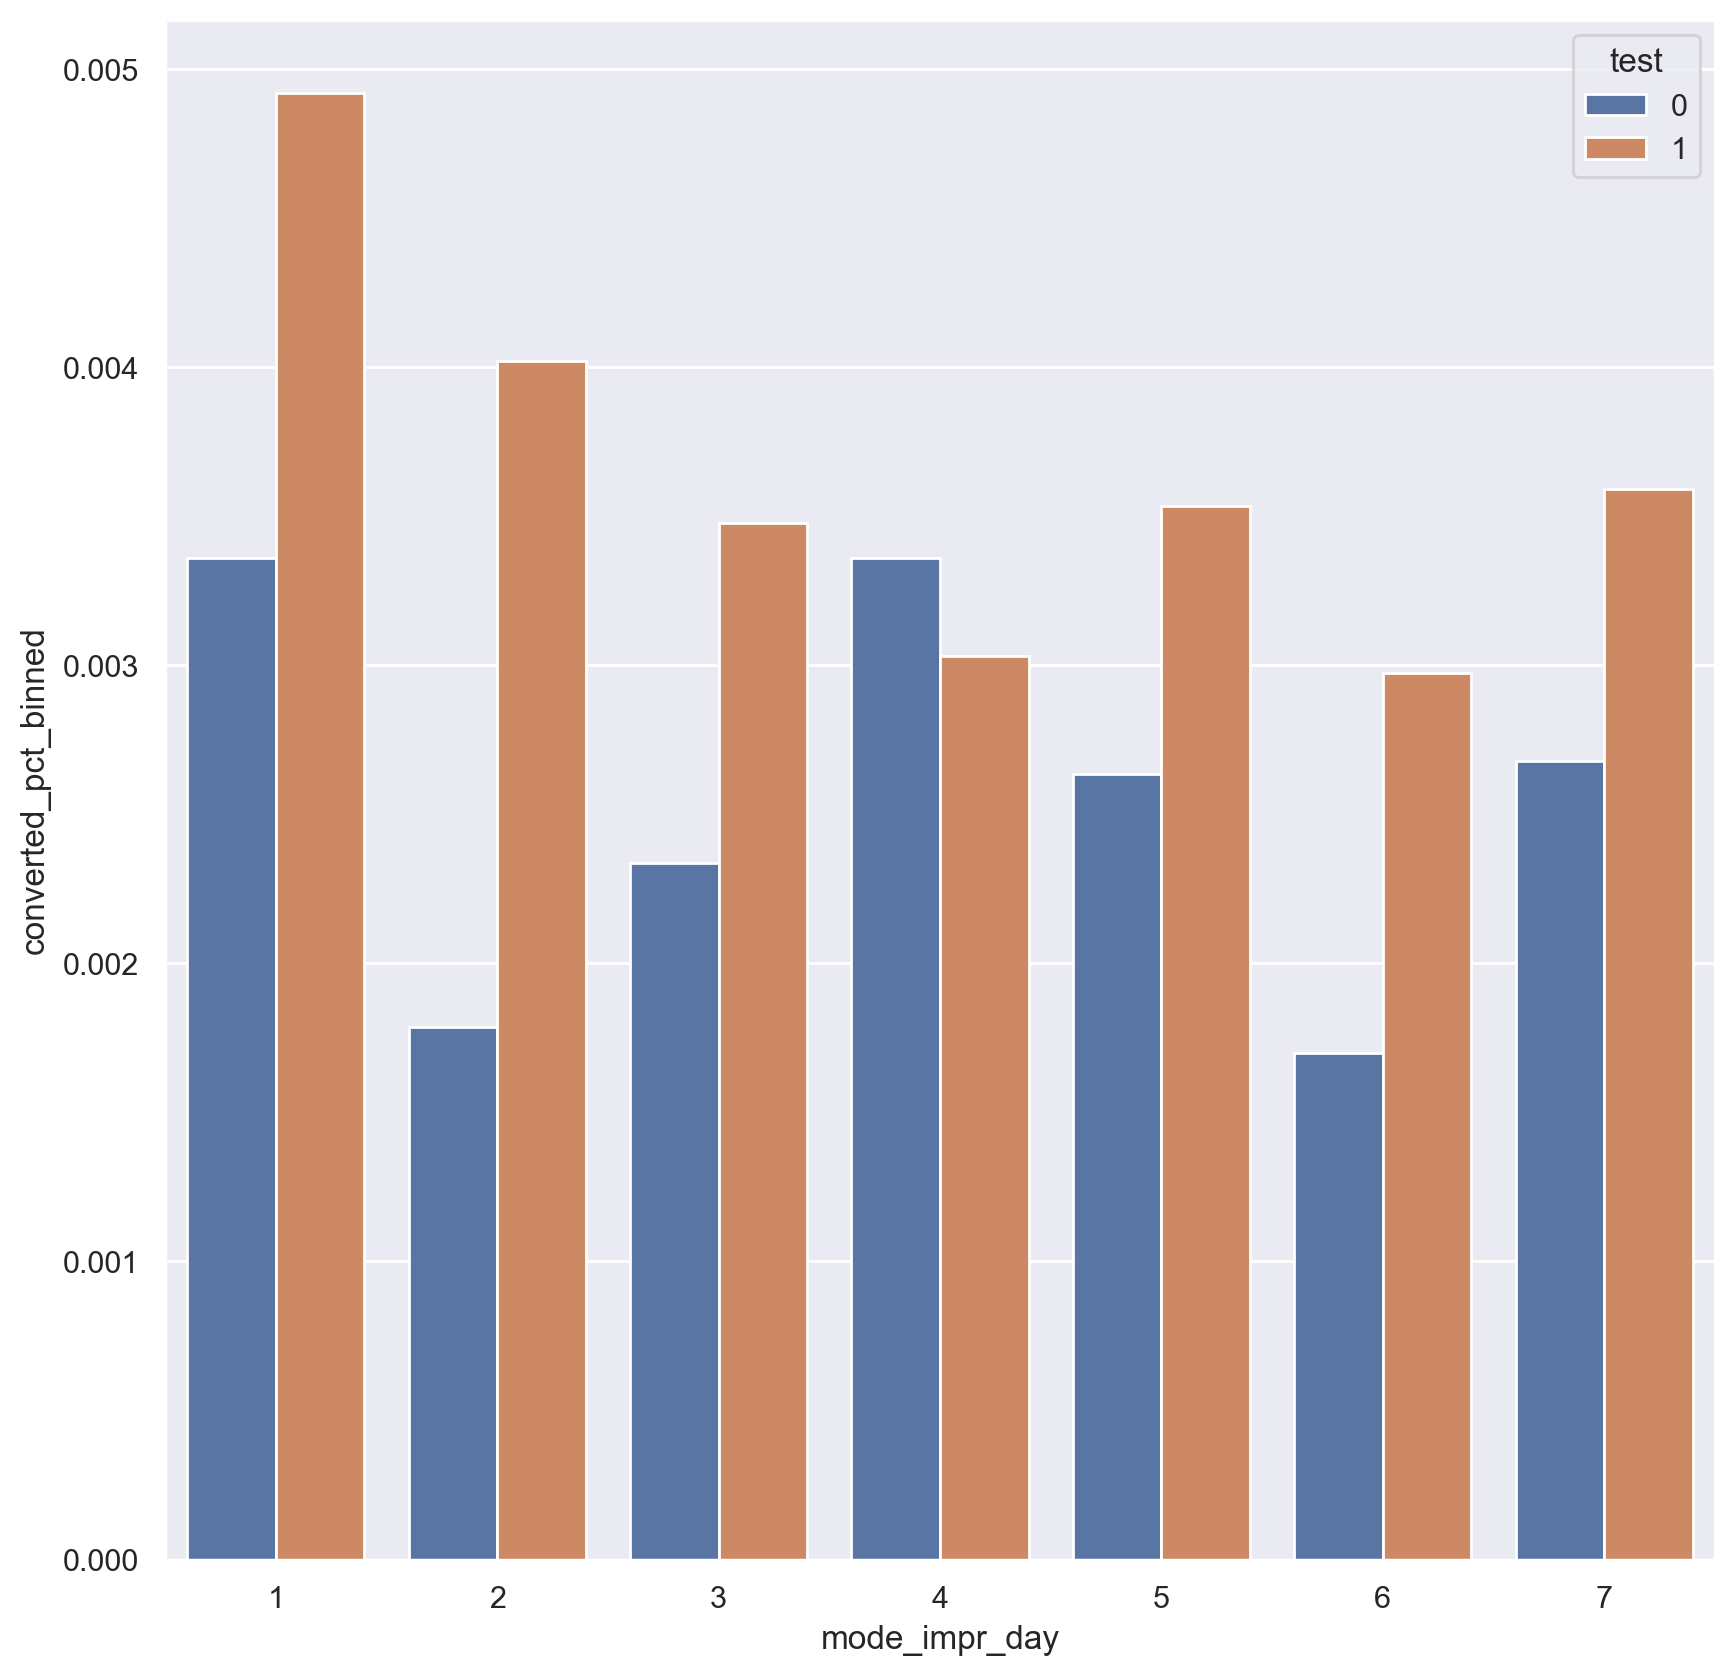

In [214]:
pt = sns.barplot(data=df2, x="mode_impr_day", y="converted_pct_binned", hue="test", errorbar="sd")

In [182]:
df3 = df.groupby(by=['test','mode_impr_day','mode_impr_hour'])['converted'].sum().reset_index()
df3

,test,mode_impr_day,mode_impr_hour,converted
0,0,1,0,0
1,0,1,1,0
2,0,1,2,0
3,0,1,3,0
4,0,1,4,0
...,...,...,...,...
330,1,7,19,161
331,1,7,20,163
332,1,7,21,136
333,1,7,22,104


In [246]:
df3['converted_pct_binned'] = df3.apply(lambda row: row['converted']/n_t if row['test'] == 1 
                                                    else row['converted']/n_c, 
                                        axis=1)
df3[~df3['mode_impr_hour'].between(0,8)]

,test,mode_impr_day,mode_impr_hour,converted,converted_pct_binned
9,0,1,9,3,0.000128
10,0,1,10,6,0.000255
11,0,1,11,8,0.000340
12,0,1,12,7,0.000298
13,0,1,13,6,0.000255
...,...,...,...,...,...
330,1,7,19,161,0.000285
331,1,7,20,163,0.000289
332,1,7,21,136,0.000241
333,1,7,22,104,0.000184


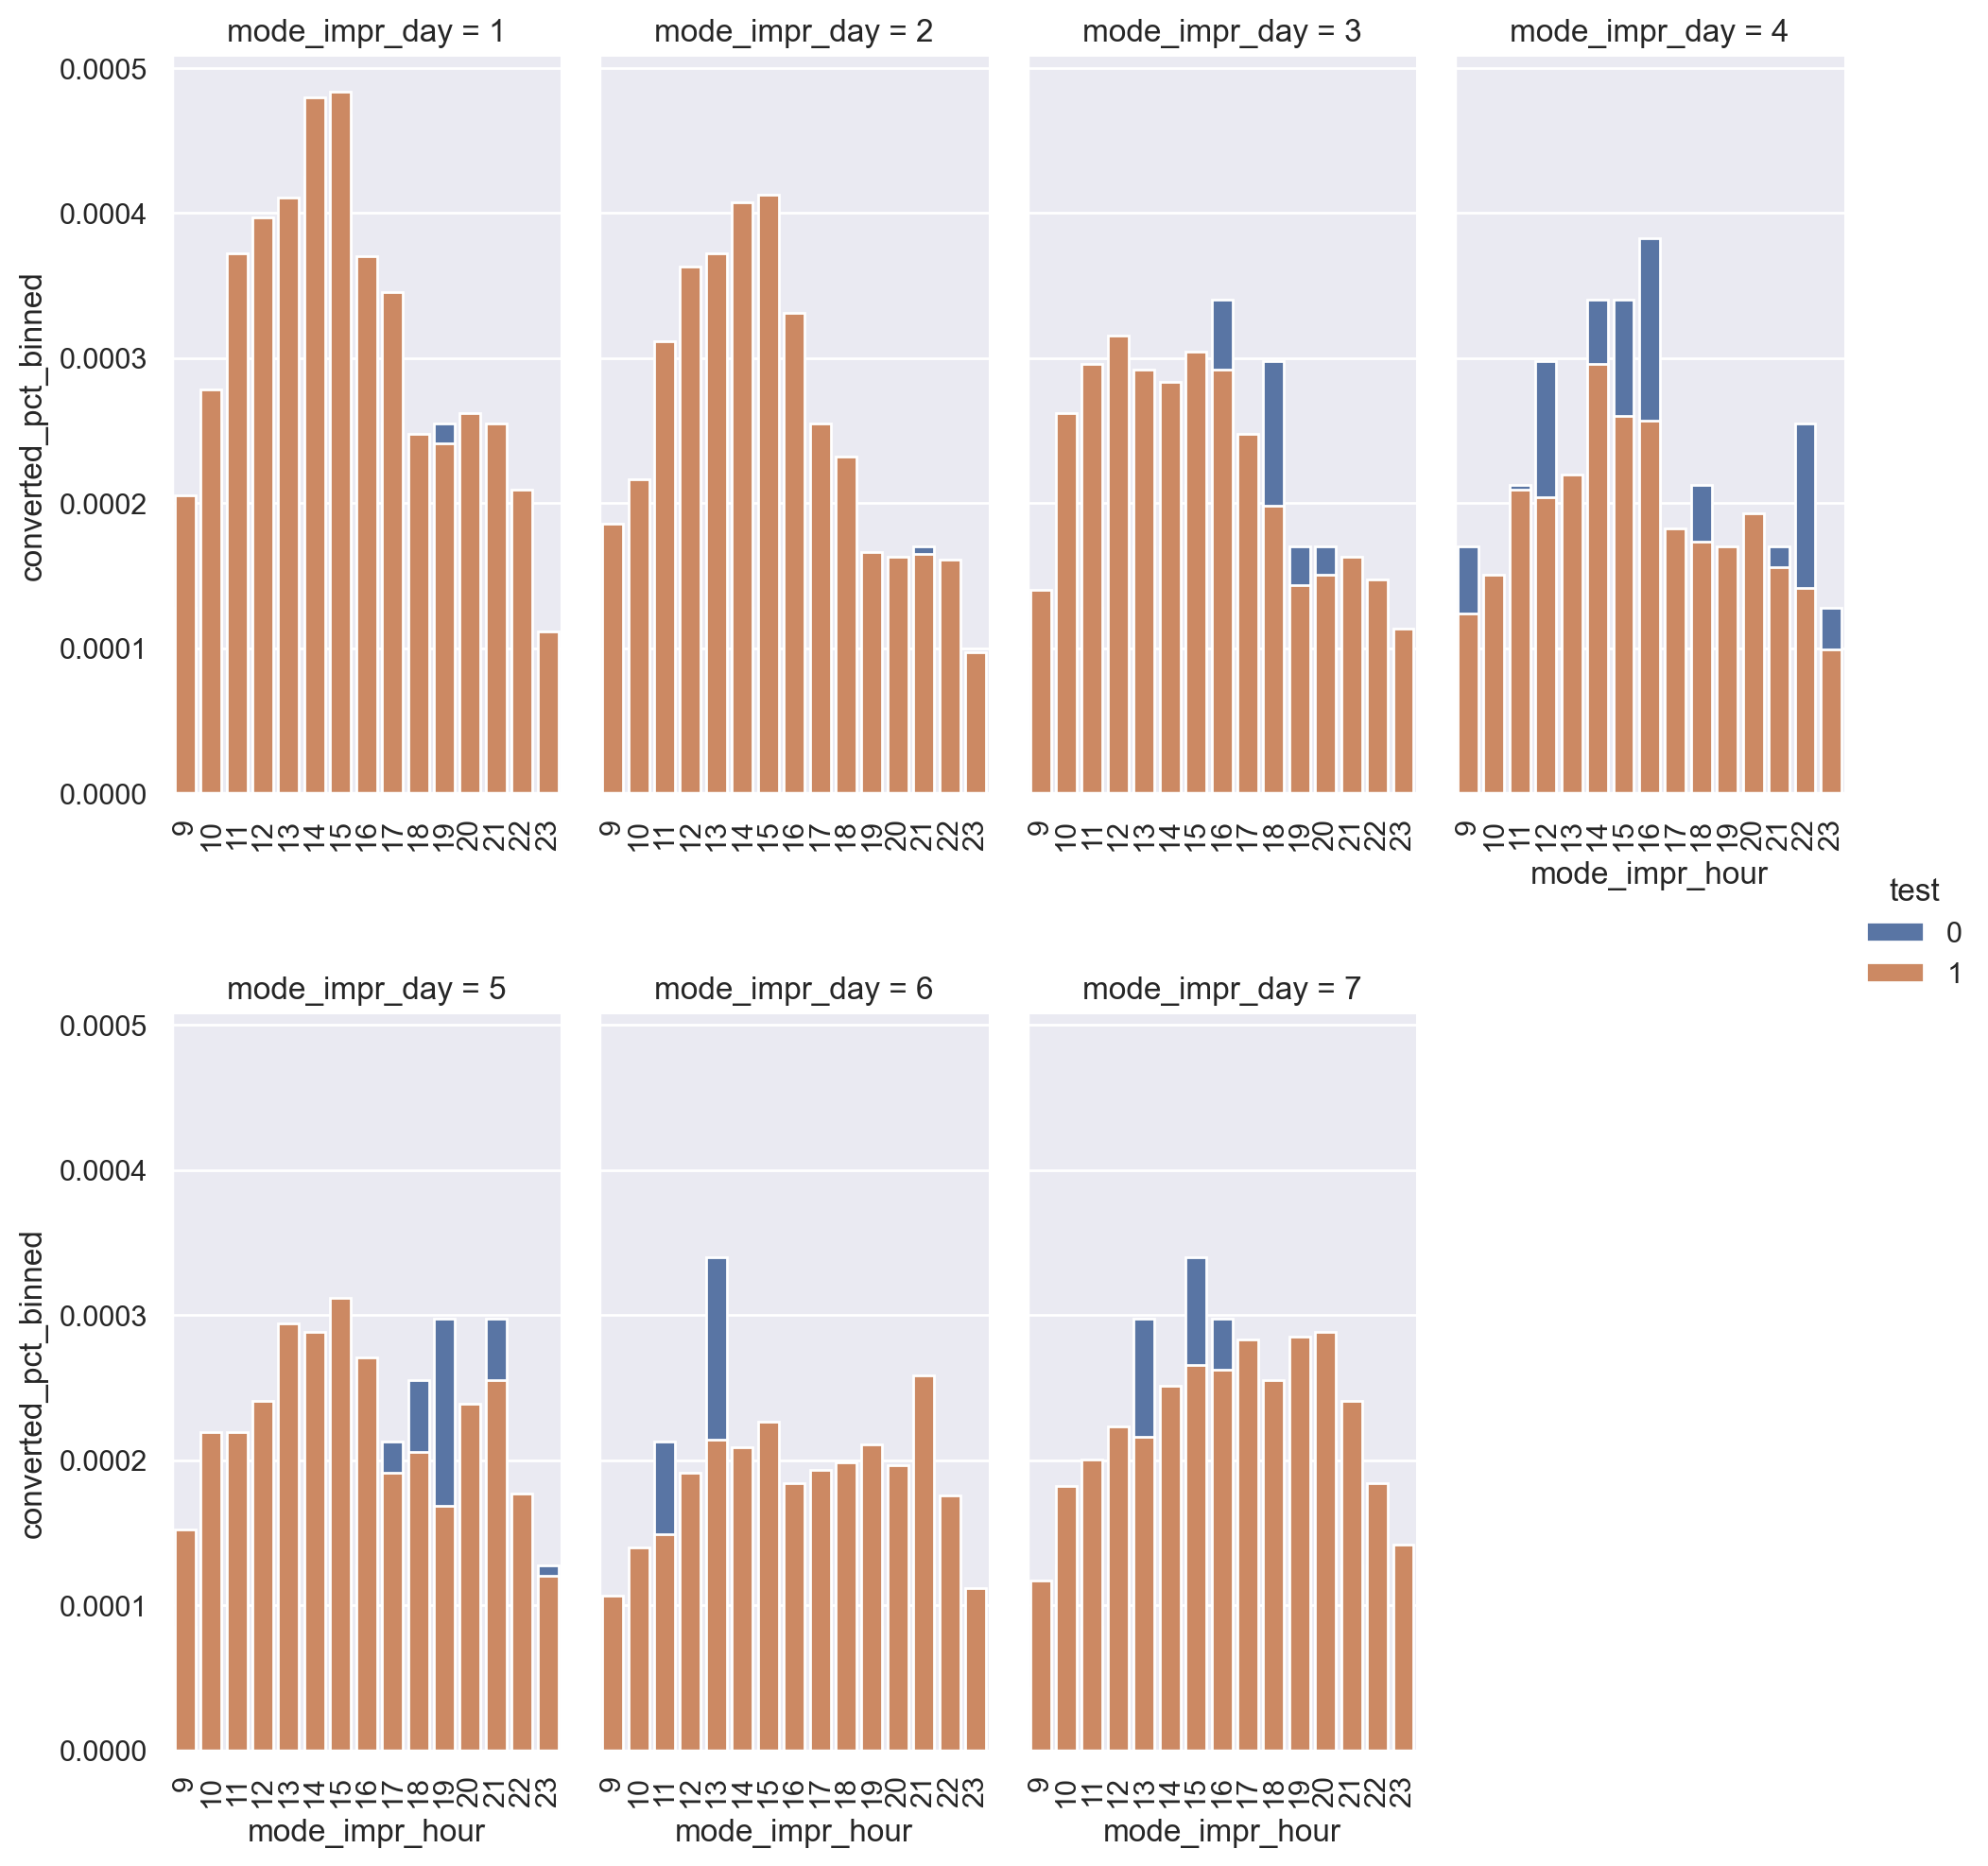

In [247]:
g = sns.FacetGrid(df3[~df3['mode_impr_hour'].between(0,8)], 
                  col="mode_impr_day", 
                  hue="test",
                  margin_titles=True,
                  sharex=False,
                  col_wrap=4, height=5, aspect=.5)

g.map(sns.barplot, 
      "mode_impr_hour", 
      "converted_pct_binned", 
      order=[i for i in range(9, 24)],)
g.add_legend()
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
plt.subplots_adjust(hspace=0.3)

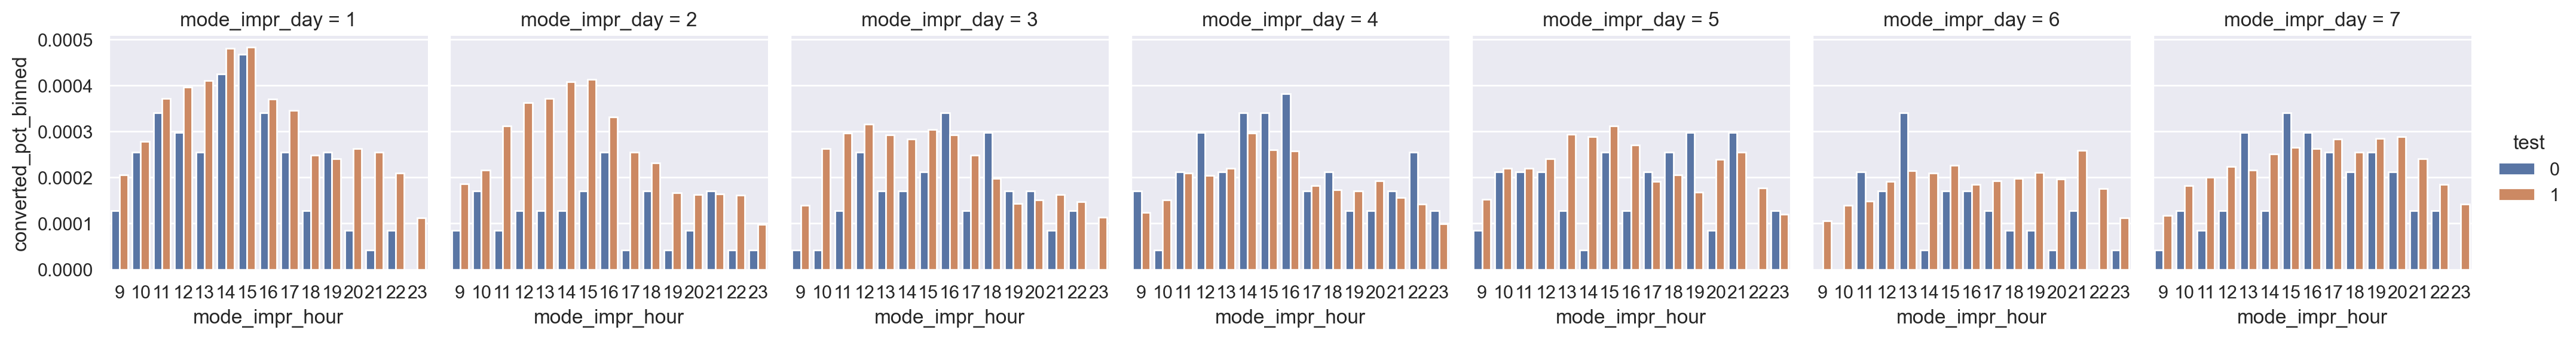

In [248]:
g = sns.catplot(
    data=df3[~df3['mode_impr_hour'].between(0,8)], 
    x="mode_impr_hour", 
    y="converted_pct_binned", 
    col="mode_impr_day", 
    hue="test",
    kind="bar", 
    height=3, 
    aspect=1,
)